In [1]:
"""
Model Based Reinforcement Learning with Analytic Mechanic
Fei, Cheung

Learning Lagrangian from Gym Pendulum
Train by Pytorch Lighting

TODO: Use configuration file to config the parameters
"""
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

from torchdyn.models import NeuralODE

from module import StructuredLNN
from nn import MLP, PSD

from gym_env import PendulumCustomEnv
from data import Gym_DataModule
from utils import plot_LNN_1D_traj, plot_LNN_1D_vector_field, plot_LNN_1D_surface

# matplotlib.use('macosx')  # Disable PyCharm SciView, Can turn on for interactive mode

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

if __name__ == "__main__":
    env = PendulumCustomEnv()
    controls = np.array([[0.]])  # (bs, dim)

    # env, time step, traj, control
    dataModule = Gym_DataModule(env, 100, 100, controls, time_horizon=5, batch_size=2048)
    dataModule.setup()

    M = PSD([1, 64, 64, 1], activation='softplus')  # Mass matrix, M(q)
    V = MLP([1, 64, 64, 1], activation='softplus')  # Potential V(q)
    LagFunc = StructuredLNN(massMatrixNet=M,
                            potentialNet=V,
                            dim=1)

    LagODE = NeuralODE(LagFunc, sensitivity='adjoint', solver='dopri5').to(device)

    def pendulum_lagrangian(q, p, l=1., m=1.):
        return p ** 2. / (2. * m * l) - m * 10. * l * (1-np.cos(q))

    class Learner(pl.LightningModule):
        def __init__(self, model: torch.nn.Module):
            super().__init__()
            self.model = model
            self.loss_func = F.mse_loss
            self.n = self.model.defunc.m.n

        def forward(self, x):
            return self.model.defunc(0, x)

        def training_step(self, batch, batch_idx):
            # Assume we have the velocity and position data
            _, _, t, x = batch

            xs0 = x[:, 0, :self.n]
            t_span = t[0, :, 0]

            dxs0 = (x[:, 1, :self.n] - x[:, 0, :self.n]) / (t[:, 1, :] - t[:, 0, :])  # finite difference

            x_dx0 = torch.cat([xs0, dxs0], dim=1)
            cur_x_hat = self.model.trajectory(x_dx0, t_span[:-1])

            loss = self.loss_func(x[:, :-1, :], cur_x_hat.transpose(0, 1))

            self.logger.experiment.add_scalars("loss", {"train": loss}, self.current_epoch)
            return loss

        def validation_step(self, batch, batch_idx):
            _, _, t, x = batch

            xs0 = x[:, 0, :self.n]
            t_span = t[0, :, 0]

            dxs0 = (x[:, 1, :self.n] - x[:, 0, :self.n]) / (t[:, 1, :] - t[:, 0, :])  # finite difference

            x_dx0 = torch.cat([xs0, dxs0], dim=1)
            cur_x_hat = self.model.trajectory(x_dx0, t_span[:-1])

            loss = self.loss_func(x[:, :-1, :], cur_x_hat.transpose(0, 1))

            self.log('val_loss', loss)
            self.logger.experiment.add_scalars("loss", {"val": loss}, self.current_epoch)
            return loss

        def configure_optimizers(self):
            return torch.optim.Adam(self.model.parameters(), lr=3e-4)

    # Use pl for training
    learn = Learner(LagODE)
    early_stopping = EarlyStopping('val_loss', verbose=True, min_delta=1e-5, patience=20)
    trainer = pl.Trainer(callbacks=[early_stopping], min_epochs=500, max_epochs=5000)  # tqdm bug mess with PyCharm
    trainer.fit(learn, dataModule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 8.7 K 
------------------------------------
8.7 K     Trainable params
0         Non-trainable params
8.7 K     Total params
0.035     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:348: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to impro

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.112
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:610: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  warning_cache.deprecation(


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 1e-05. New best score: 0.102


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 1e-05. New best score: 0.093


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 1e-05. New best score: 0.086


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 1e-05. New best score: 0.079


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 1e-05. New best score: 0.073


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 1e-05. New best score: 0.068


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 1e-05. New best score: 0.063


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 1e-05. New best score: 0.060


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 1e-05. New best score: 0.057


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.055


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.053


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.052


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.052


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.052


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.052


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.052


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.051


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.051


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.051


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.051


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.051


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.051


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.050


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.050


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.050


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.050


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.050


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.050


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.049


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.049


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.049


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.049


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.049


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.048


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.048


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.048


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.048


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.048


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.047


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.047


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.047


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.046


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.046


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.046


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.045


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.045


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.045


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.045


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.044


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.044


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.044


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.044


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.043


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.043


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.043


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.042


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.042


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.042


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.041


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.041


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.041


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.040


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.040


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.040


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.040


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.039


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.039


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.038


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.038


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.038


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.037


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.037


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.036


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.036


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.036


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.036


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.036


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.034


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.034


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.033


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.032


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.031


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:897: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn('Detected KeyboardInterrupt, attempting graceful shutdown...')


/Users/fei/Documents/UCL/Thesis/Code/MBRL_HNN/utils/LNN_plot.py:79: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/fei/Documents/UCL/Thesis/Code/MBRL_HNN/utils/LNN_plot.py:125: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


done


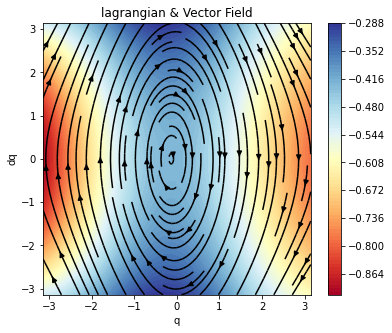

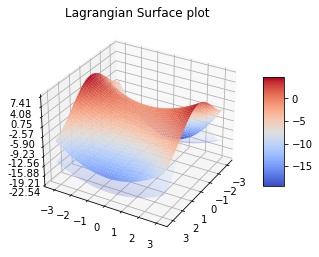

In [2]:
# TODO: Add animation on how the learned hamiltonian evolve
# Test for the Learned model
# plot_LNN_1D_traj(HamODE)
plot_LNN_1D_vector_field(LagODE)
plot_LNN_1D_surface(LagODE, ground_truth=pendulum_lagrangian)

# log can be view using tensorboard
# tensorboard --logdir ./experiment/exp_HNN/lightning_logs
print("done")


In [3]:
env.seed(0)
init = env.reset(np.array([0.5, 0.]))

obs = []
for i in range(1000):
    cur_obs, reward, done, info = env.step(0)
    obs.append(np.array([info['theta'], info['theta_dot']]))
    
obs = torch.tensor(obs)
print(init)

[-0.87758256  0.47942554  0.        ]


In [4]:
step = 1000
dx0 = dxs0 = (obs[1, :1] - obs[0, :1]) / 0.05
x0 = obs[0, :1]

x_dx0 = torch.unsqueeze(torch.cat([x0, dxs0], dim=0), dim=0)
t_span = torch.linspace(0, 0.05*step, step)
est = learn.model.trajectory(x_dx0.float(), t_span)
print(est.shape)
print(obs.shape)

torch.Size([1000, 1, 2])
torch.Size([1000, 2])


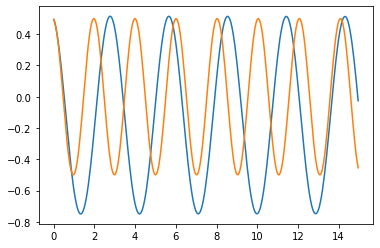

In [5]:
time = 300
plt.plot(t_span.detach().numpy()[:time], est[:time, 0, 0].detach().numpy())
plt.plot(t_span.detach().numpy()[:time], obs[:time, 0])
plt.show()

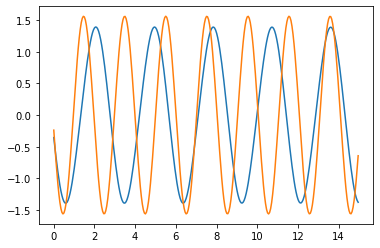

In [6]:
plt.plot(t_span.detach().numpy()[:time], est[:time, 0, 1].detach().numpy())
plt.plot(t_span.detach().numpy()[:time], obs[:time, 1])
plt.show()

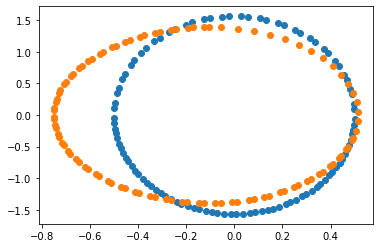

In [7]:
plt.scatter(obs[:100, 0], obs[:100, 1])
plt.scatter(est[:100, 0, 0].detach().numpy(), est[:100, 0, 1].detach().numpy())

# Because lack of the data near the region -> under estaimte